In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from math import ceil
from image import *
from image_utils import *
from stitch import *

In [2]:
rm ../data/nevada/panorama.jpg

rm: cannot remove '../data/nevada/panorama.jpg': No such file or directory


In [3]:
images = read_images("../data/UB/")

Reading ../data/UB/img3.jpg
Reading ../data/UB/img1.jpg
Reading ../data/UB/img2.jpg


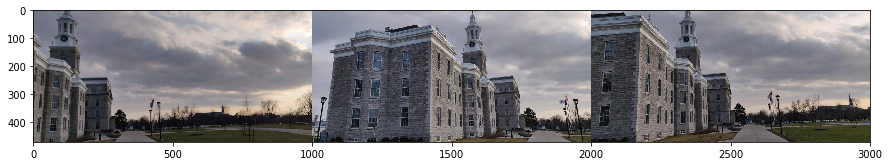

In [7]:
show_image(np.hstack((images[0].img, images[1].img, images[2].img)))

In [ ]:
for img in images[:-1]:
    img.show()

In [ ]:
def warp_two_images(img1, img2, h):
    """Warps the given image img1 to img2 using homographt matrix h.

    Arguments:
        img1 {np.ndarray} -- Image to be warped
        img2 {np.ndarray} -- Image to which img1 has to be warped
        h {np.ndarray} -- Homography matrix

    Returns:
        np.ndarray -- Image resulting after warping img1 to img2
    """

    # Find the shape
    y1, x1 = img1.shape[:2]
    y2, x2 = img2.shape[:2]

    # Get the corners of the images
    pts1 = np.array([[0, 0], [0, y1], [x1, y1], [x1, 0]],
                    dtype=np.float32).reshape(-1, 1, 2)
    pts2 = np.array([[0, 0], [0, y2], [x2, y2], [x2, 0]],
                    dtype=np.float32).reshape(-1, 1, 2)

    # Get the points after applying homography
    pts2_ = cv2.perspectiveTransform(pts2, h)
    pts = np.concatenate((pts1, pts2_), axis=0)

    # Round off the points
    [xmin, ymin] = np.array(pts.min(axis=0).flatten() - 0.5, dtype=np.int32)
    [xmax, ymax] = np.array(pts.max(axis=0).flatten() + 0.5, dtype=np.int32)

    # Compute the translation homography matrix
    warped_img = [-xmin, -ymin]
    h_dash = np.array(
        [[1, 0, warped_img[0]], [0, 1, warped_img[1]], [0, 0, 1]])  # translate

    # Use the translation homography matrix to fit bot img1 and img2 on mossiac
    result = cv2.warpPerspective(img2, h_dash.dot(h), (xmax-xmin, ymax-ymin))
    result_copy = result.copy()
    result2 = np.zeros_like(result)
    result2[warped_img[1]:y1+warped_img[1],warped_img[0]:x1+warped_img[0]] = img1
    
    show_image(result)
    show_image(result2)
    
#     result[]
#     return result[:, ]
    mask = np.logical_not(np.logical_and(result > 0, result2 > 0))
    mask_mask = np.where(mask != True)
    print(mask_mask)
    
    blend = np.zeros_like(result[:, :, 0])
    n = (np.min(mask_mask[1]), np.max(mask_mask[1]))
    blend[:, n[0]: n[1]:] = np.tile(np.linspace(0, 255, abs(n[0] - n[1])), 3).reshape
#     result2[mask] = 0
#     result[mask] = 0
#     return result2
   
    merged = cv2.addWeighted(result, 0.5, result2, 0.5, 0) 
    result = result * np.logical_not(mask) + merged
    return result




In [ ]:
matches = knn_matcher(images[0].descriptors, images[1].descriptors)

# Compute the homography using ransac
h = ransac(matches, images[0].keypoints, images[1].keypoints,
           sample_points=10, iterations=10000, check=False)

res = warp_two_images(images[1].img, images[0].img, h)

In [ ]:
res.shape

In [ ]:
show_image(res)